# **ATP Match Data Elo Ratings**

In this notebook we construct pre and post-match Elo ratings for both players in each match. These can be used to predict winners. We also will attempt to use these as a predictor in a model of win probability alongside other features. 

Note that predictions solely based on Elo ratings generally perform very well. They can predict in the range of 70% of match winners correctly. Some of my research also indicated that they generally outperform regression-type models. So it may interesting to combine these approaches. 

For a little background on Elo ratings, they were originally developed by [Arpad Elo](https://en.wikipedia.org/wiki/Arpad_Elo) as a way to calcualte relative skill for players two player games like chess. They have been widely applied to other games, including tennis. 

The traditional Elo rating is very simple. Players start with a rating of 1500. When player A and player B are pitted against one antoher, the probability of each player winning is a logistic function of the relative ratings:

$$\begin{aligned}
\mathbb{P}(\text{Player A Wins}) &= \frac{1}{1+10^{(\text{Rating}_B - \text{Rating}_A)/400}} \\
\mathbb{P}(\text{Player B Wins}) &= \frac{1}{1+10^{(\text{Rating}_A - \text{Rating}_B)/400}} = 1-\mathbb{P}(\text{Player A Wins})
\end{aligned}$$

After the match is played, the two players ratings are updated as:

$$\begin{aligned}
\text{Rating}_A &\leftarrow \text{Rating}_A + K(\text{Score}_A - \mathbb{P}(\text{Player A Wins})) \\
\text{Rating}_B &\leftarrow \text{Rating}_B + K(\text{Score}_B - \mathbb{P}(\text{Player B Wins}))
\end{aligned}$$

Where $\text{Score}$ is 1 for the player that won but 0 for the player that lost. When the results of a match are consistent with the relative ratings of the players, the winner's rating is increased but by less than if the winner was not expected to win. Similarly, the loser's rating is decreased but by less than if the loser was not expected to lose. The opposite is true when the result of a match runs against expectations. In this case, the system sees that the ratings might be out of line with skill levels and adjusts more dramatically.  

$K$ is a measure of match importance. We will make $K$ a function of the number of matches played and of the tournament level and round of the tournament. We use the ATP point allocations to account for the latter two. That is, Grand Slams award points in the following manner:
- Winner: 2,000
- Runner-Up: 1,200
- Semi-Finalist: 720
- Quarter-Finalist: 360
- 4th Round: 180
- 3rd Round: 90
- 2nd Round: 45
- 1st Round: 10

Masters 1000 events divide these by half. ATP 500 divide in half agian. and ATP 250 does so again. ATP finals give the winner 1500, the runner up 500, semi-finalists 400, and wins in the round robin 200. Our data breaks our Grand Slams, Masters 1000s, ATP finals, and "other tour-level events". So we'll just treat all "other" events as ATP 500, though we could create a tournament level mapping. We'll divide the points by 1000 to get our multiplier that captures match importance, $K_1 = \text{ATP Points}/1000$. Note that we use the points for the next round. For example, for a semi-final the points we use to determine the importance is 1,200 since this is what the winner of a semi-final would lock in if they win the semi-final. 

We also use a second multiplier for number of matches played: $K_2 = 100/((N+1)^{0.25})$, where $N$ is the number of matches the player has played up to the current match. This allows for players with established ratings to be less effected by each additional match. Then the full match importance will be $K = K_1 \times K_2$.



There are several other things that we might want to adjust for relative to the vanilla Elo rating. This include:
- account for 3 vs 5 sets
- account for surface 
- reduce ratings when players miss long stretches
- account for how much they won by

For now, we just get the vanilla Elo ratings.

Note that this work draws on a few articles:
- [An Introduction to Tennis Elo](http://www.tennisabstract.com/blog/2019/12/03/an-introduction-to-tennis-elo/)
- [Djokovic And Federer Are Vying To Be The Greatest Of All Time](https://fivethirtyeight.com/features/djokovic-and-federer-are-vying-to-be-the-greatest-of-all-time/)
- [An Introduction to Tennis Modelling](https://www.betfair.com.au/hub/an-introduction-to-tennis-modelling/)
- [Brier score composition – A mini-tutorial](https://timvangelder.com/2015/05/18/brier-score-composition-a-mini-tutorial/)
- [Wikipedia - Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system#:~:text=The%20Elo%20rating%20system%20is,a%20Hungarian%2DAmerican%20physics%20professor.&text=Two%20players%20with%20equal%20ratings,an%20equal%20number%20of%20wins.)

First, let's mount the google drive, import libraries we need, and connect to our SQL database. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 

In [4]:
connection = sqlite3.connect('/content/drive/My Drive/ATP Tennis/Database/ATP_Tennis.db')
c = connection.cursor()

To calculate Elo ratings, we first need the matches to be sorted in order of date played. The data we have only has one date per tournament, but we also have the round. So we are able to sort by year, tournament date, tournament ID, and round. We will iterate over each match updating the Elo ratings of the two players. 

In [5]:
c.execute('''
SELECT *
FROM ATP_MATCHES 
ORDER BY year 
''')
Matches = pd.DataFrame(c.fetchall(),columns=[c.description[i][0] for i in range(len(c.description))])
round_order = dict(Counter(Matches["round"]))
round_order["BR"] = 1
round_order["ER"] = 2
round_order["RR"] = 3
round_order["R128"] = 4
round_order["R64"] = 5
round_order["R32"] = 6
round_order["R16"] = 7
round_order["QF"] = 8
round_order["SF"] = 9
round_order["F"] = 10
Matches['round_order'] = Matches['round'].map(round_order)
Matches = Matches.sort_values(by=['year', 'tourney_date','tourney_id','round_order','match_num']).reset_index()
Matches["MatchEloID"] = Matches.index 
Matches["PreMatchElo_Winner"] = 0
Matches["PreMatchElo_Loser"] = 0
Matches["PostMatchElo_Winner"] = 0
Matches["PostMatchElo_Loser"] = 0
Matches["PreMatchCount_Winner"] = 0
Matches["PreMatchCount_Loser"] = 0

Then we assign the match importance for each match based on tournament level and round. 

In [6]:
round_points = round_order
round_points["BR"] = 0.200
round_points["ER"] = 0.200
round_points["RR"] = 0.200
round_points["R128"] = 0.045
round_points["R64"] = 0.090
round_points["R32"] = 0.180
round_points["R16"] = 0.360
round_points["QF"] = 0.720
round_points["SF"] = 1.200
round_points["F"] = 2.000
Matches['match_points'] = Matches['round'].map(round_points)
Matches['match_points'] = np.where(Matches["tourney_level"]=="M",
                                   Matches['match_points']/2,Matches['match_points'])
Matches['match_points'] = np.where(Matches["tourney_level"]=="A",
                                   Matches['match_points']/4,Matches['match_points'])
Matches['match_points'] = np.where((Matches["tourney_level"]=="F") & (Matches['round'] == "F"),
                                   1.500,Matches['match_points'])
Matches['match_points'] = np.where((Matches["tourney_level"]=="F") & (Matches['round'] == "SF"),
                                   0.500,Matches['match_points'])
Matches['match_points'] = np.where((Matches["tourney_level"]=="F") & (Matches['round'] == "QF"),
                                   0.400,Matches['match_points'])

We also need a dictionary of the players' current Elo ratings. All of these start at 1500. They will be updated as we work through each match. We also create a dictionary that will track the current number of matches that each player has played.   

In [7]:
c.execute('''
SELECT player
FROM ATP_PLAYERS
''')
Players = pd.DataFrame(c.fetchall(),columns=[c.description[i][0] for i in range(len(c.description))])
Players["Elo_Rating"] = 1500.0
Players["MatchCount"] = 0
EloRatings = dict(zip(Players.player,Players.Elo_Rating))
MatchCounts = dict(zip(Players.player,Players.MatchCount))

Now we define a function that updates the Elo ratings in our dictionaries and populates the ratings relevant to each match. We then run this funciton for each match. 

In [8]:
def EloUpdate(MatchID): 
  '''
  This function updates the Elo ratings and match counts of the players 
  participating in match number MatchID. 
  '''
  #Pull Player IDs and Match Importance Based on ATP Points
  WinnerID,LoserID = Matches.iloc[MatchID]["winner_id"],Matches.iloc[MatchID]["loser_id"]
  MIATPPoints = Matches.iloc[MatchID]["match_points"]

  #Calculate Match Importance based on Number of Matches Played
  MatchesPlayedWinner = MatchCounts[WinnerID]
  MatchesPlayedLoser = MatchCounts[LoserID]
  MIMatchesPlayedWinner = 100/((MatchesPlayedWinner+1)**0.25)
  MIMatchesPlayedLoser = 100/((MatchesPlayedLoser+1)**0.25)

  #Pull Player Elo Ratings
  WinnerRating,LoserRating = EloRatings[WinnerID],EloRatings[LoserID]

  #Populate Pre-Match Elo Ratings and Match Counts in Match Data
  Matches.iloc[MatchID,Matches.columns.get_loc("PreMatchElo_Winner")] = WinnerRating
  Matches.iloc[MatchID,Matches.columns.get_loc("PreMatchElo_Loser")] = LoserRating
  Matches.iloc[MatchID,Matches.columns.get_loc("PreMatchCount_Winner")] = MatchesPlayedWinner
  Matches.iloc[MatchID,Matches.columns.get_loc("PreMatchCount_Loser")] = MatchesPlayedLoser

  #Calculate Player Win Probabilities 
  WinProbA = 1.0 / (1 + 10**((LoserRating - WinnerRating) / 400))
  WinProbB = 1 - WinProbA

  #Update Player Ratings based on Current Match Result
  WinnerRating += (1+MIATPPoints)*MIMatchesPlayedWinner*(1-WinProbA)
  LoserRating += (1+MIATPPoints)*MIMatchesPlayedLoser*(-WinProbB) 

  #Update Ratings and Match counts in Dictionaries
  EloRatings[WinnerID],EloRatings[LoserID] = round(WinnerRating,6),round(LoserRating,6)
  MatchCounts[WinnerID] += 1
  MatchCounts[LoserID] += 1

  #Populate Post-Match Elo Ratings in Match Data
  Matches.iloc[MatchID,Matches.columns.get_loc("PostMatchElo_Winner")] = round(WinnerRating,6)
  Matches.iloc[MatchID,Matches.columns.get_loc("PostMatchElo_Loser")] = round(LoserRating,6)


for i in range(Matches.shape[0]):
  EloUpdate(i)

In [10]:
Matches.to_sql('ATP_MATCHES', connection, if_exists='replace', index = False)

To check that our Elo ratings look right, we define a function to get the Elo ratings for all of a player's matches. We then use this to get the Elo ratings for the big four and plot their ratings across matches. We see roughly the same trajectories as does this [article](https://fivethirtyeight.com/features/djokovic-and-federer-are-vying-to-be-the-greatest-of-all-time/). So we're on the right track. Note that the article is from 2015 and so has less data than we do. We also dont use data from the 1980s so Elo ratings for players like Sampras and Agassi dont capture their whole careers. Also note that the method presented here is not attempting to replicate this article or any other previous Elo system. So while trajectories are similar, they are not idenitcal. 

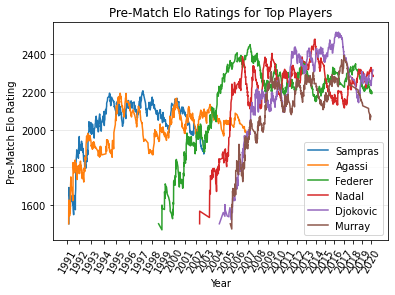

In [9]:
def getPlayerEloData(player):
  ply_wins = Matches[Matches["winner_name"]==player]
  ply_loss = Matches[Matches["loser_name"]==player]
  ply_wins = ply_wins[["MatchEloID","year","winner_name","PreMatchElo_Winner","PostMatchElo_Winner","PreMatchCount_Winner"]]
  ply_loss = ply_loss[["MatchEloID","year","loser_name","PreMatchElo_Loser","PostMatchElo_Loser","PreMatchCount_Loser"]]
  ply_WL = pd.concat([ply_wins,ply_loss]).sort_values(by="MatchEloID")
  ply_WL["PreMatchElo"] = np.where(ply_WL["PreMatchElo_Winner"].notnull(),ply_WL["PreMatchElo_Winner"],ply_WL["PreMatchElo_Loser"])
  ply_WL["PostMatchElo"] = np.where(ply_WL["PostMatchElo_Winner"].notnull(),ply_WL["PostMatchElo_Winner"],ply_WL["PostMatchElo_Loser"])
  ply_WL["PreMatchCount"] = np.where(ply_WL["PreMatchCount_Winner"].notnull(),ply_WL["PreMatchCount_Winner"],ply_WL["PreMatchCount_Loser"])
  return ply_WL[["MatchEloID","year","PreMatchElo","PostMatchElo","PreMatchCount"]]

PS = getPlayerEloData("Pete Sampras")
AA = getPlayerEloData("Andre Agassi")
RF = getPlayerEloData("Roger Federer")
RN = getPlayerEloData("Rafael Nadal")
ND = getPlayerEloData("Novak Djokovic")
AM = getPlayerEloData("Andy Murray")

min_id_by_year = pd.DataFrame(Matches.groupby('year')['MatchEloID'].agg('min'))
min_id_by_year['year'] = min_id_by_year.index

plt.plot(PS["PreMatchElo"],label="Sampras")
plt.plot(AA["PreMatchElo"],label="Agassi")
plt.plot(RF["PreMatchElo"],label="Federer")
plt.plot(RN["PreMatchElo"],label="Nadal")
plt.plot(ND["PreMatchElo"],label="Djokovic")
plt.plot(AM["PreMatchElo"],label="Murray")
plt.title("Pre-Match Elo Ratings for Top Players")
plt.ylabel("Pre-Match Elo Rating")
plt.xlabel("Year")
plt.xticks(min_id_by_year['MatchEloID'],min_id_by_year['year'],rotation=60)
plt.legend()
plt.grid(axis="y",alpha=0.3)
plt.show()